# Time Stamp Extraction
It appears that the time stamps on the cameras differ from the data logs. Therefore, it might be a good exercise  to extract the cameras' timestamps from the images.

This notebook presents two methods:
1. Using the OCR package Tesseract
2. Building a custom OCR from scratch

In [4]:
import os, sys, datetime
import numpy as np
import pandas as pd
jp = os.path.join

In [3]:
DATADIR = 'data'

In [230]:
df = pd.read_excel(jp(DATADIR, 'Image Log Master File for GSU.xlsx'))
df.rename(columns=lambda x: x.replace(' ', '').replace('@', '').replace('#', '').replace('/', '_'), inplace=True)
df.index = df.Ticket
df['FN'] = [ 'data/Ticket %s/%s' % (r.Ticket, r.ImageFileName.split("'")[1]) for r in df.itertuples()]

In [ ]:
df.head()

In [231]:
df.shape

(256, 22)

# Tesseract OCR

https://github.com/tesseract-ocr/tesseract/blob/master/README.md

Tesseract was originally developed at Hewlett-Packard Laboratories Bristol and at Hewlett-Packard Co, Greeley Colorado between 1985 and 1994, with some more changes made in 1996 to port to Windows, and some C++izing in 1998.
In 2005 Tesseract was open sourced by HP. Since 2006 it is developed by Google.

http://stackoverflow.com/questions/2363490/limit-characters-tesseract-is-looking-for

In [351]:
from PIL import Image, ImageChops
import pytesseract
import scipy.misc

Let's start with a picture. The time-stamp is in the upper left corner. About 160 pixels wide and 16 pixels high.


In [ ]:
img = Image.open(df.iloc[34].FN)
img

Let's zoom in ... crop the time-stamp

In [359]:
tsimg = img.crop(box=(0, 0, 160, 16))   ## left upper right lower
tsimg

## Testing parameters
Let's see how well Tesseract works...
The first attempts weren't that great. Though there are a couple of things one can improve
1. Limit the set of characters that the OCR should consider
2. Modify the image

In [360]:
pytesseract.image_to_string(tsimg)

'2u15/11/UE D7 31 43'

In [361]:
pytesseract.image_to_string(tsimg, config='-c tessedit_char_whitelist=0123456789/:')

'2015/11/03 :17 31 43'

Even with a smaller character set the recognition isn't great. The OCR may have difficulties because the digits are only 1 pixel thick. Let's scale it up by factor 4

OCR Output:  2016: 11 /08 07:31:43


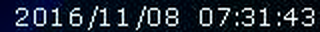

In [367]:
tsimg1 = tsimg.resize((320,32), resample=Image.LANCZOS )
print "OCR Output: ", pytesseract.image_to_string(tsimg1, config='-c tessedit_char_whitelist=0123456789/:')
tsimg1

That's better but still not accurate

OCR Output:  2016 11 08 07 :31:43


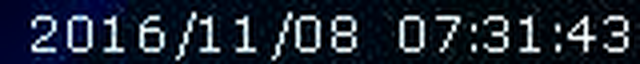

In [382]:
tsimg1 = tsimg.resize((640,64), resample=Image.LANCZOS )
print "OCR Output: ", pytesseract.image_to_string(tsimg1, config='-c tessedit_char_whitelist=0123456789/:')
tsimg1

OCR Output:  2016/11/08 07:31:43


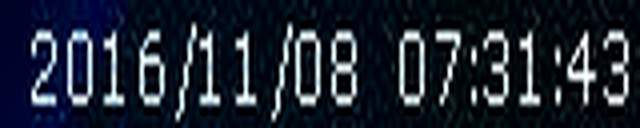

In [383]:
tsimg3 = tsimg.resize((640,128), resample=Image.LANCZOS)
print "OCR Output: ", pytesseract.image_to_string(tsimg3, config='-c tessedit_char_whitelist=0123456789/:')
tsimg3

There we go. The font in the camera picture is squashed, and the slashes are as prominent as the digits. Therby confusing the OCR engine. By changing the aspect ratio of the image we can help.

# OCR from scratch
While the Tessearact package works pretty well, we can perform this task from scratch. This demonstrate how to operate on images.

In [56]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

The OpenCV package allows us to treat images as matrices (and tensors). It also has a comprehensive collection of image processing routines.

In [92]:
img = cv2.imread(df.iloc[0].FN)
img = cv2.cvtColor(img, cv2.cv.CV_BGR2RGB)

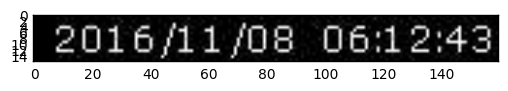

In [93]:
plt.imshow(img[0:16, 0:160 ])

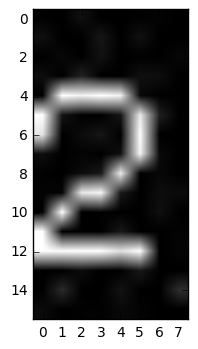

In [94]:
plt.imshow(img[0:16, 8:16])

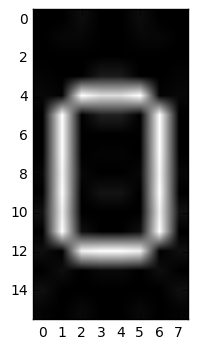

In [79]:
plt.imshow(img[0:16, 16:24])

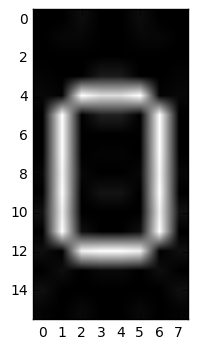

In [97]:
plt.imshow(img[0:16, 16:24].mean(axis=2), cmap='gray')

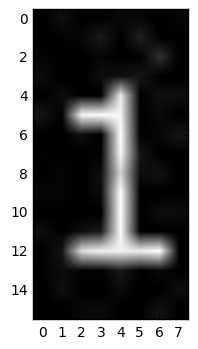

In [99]:
i1 = img[0:16, 24:32]
plt.imshow(i1)

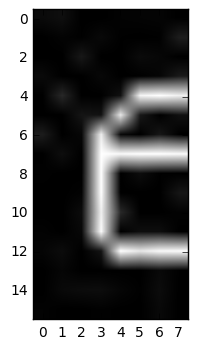

In [100]:
i2 = img[0:16, 32:40]
plt.imshow(i2)

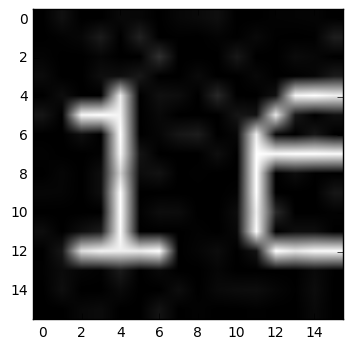

In [107]:
plt.imshow(np.concatenate([i1, i2], axis=1))

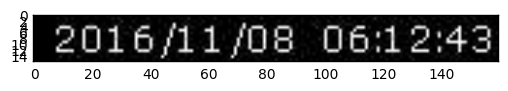

In [114]:
tsimg = img[0:16, 0:160]
plt.imshow(tsimg)

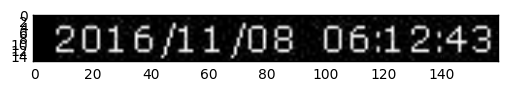

In [115]:
gtsimg = tsimg.mean(axis=2)
plt.imshow(gtsimg, cmap='gray')

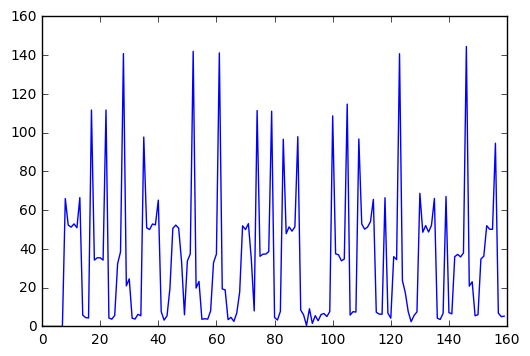

In [117]:
plt.plot(gtsimg.mean(axis=0))

In [234]:
imgs = []
for r in df.itertuples():
    img = cv2.imread(r.FN)
    img = cv2.cvtColor(img, cv2.cv.CV_BGR2RGB)
    tsimg = img[0:16, 0:160].mean(axis=2)
    imgs.append(tsimg)
print("Number of images=%d"%len(imgs))

Number of images=256


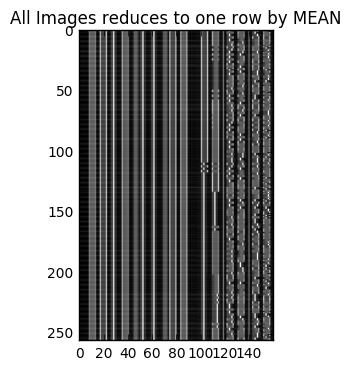

In [248]:
allimgs = np.concatenate([i.mean(axis=0).reshape(160,1) for i in imgs], axis=1)
plt.title('All Images reduces to one row by MEAN')
plt.imshow(allimgs.T, cmap='gray')

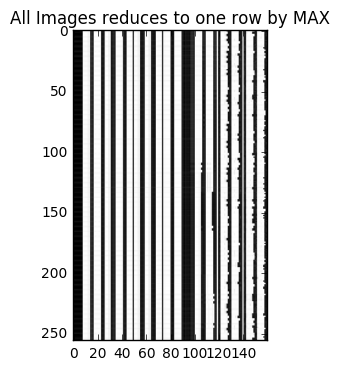

In [249]:
allimgs2 = np.concatenate([i.max(axis=0).reshape(160,1) for i in imgs], axis=1)
plt.title('All Images reduces to one row by MAX')
plt.imshow(allimgs2.T, cmap='gray')

In [212]:
len(imgs)

256

In [142]:
imgs[0].mean(axis=2).shape

(16, 160)

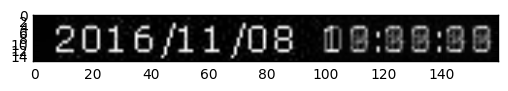

In [144]:
avgimg = imgs[0].mean(axis=2)
for k in range(1, len(imgs)):
    avgimg += imgs[k].mean(axis=2)
avgimg/len(imgs)
plt.imshow(avgimg, cmap='gray')

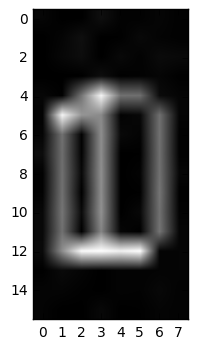

In [153]:
plt.imshow(avgimg[:,99:107], cmap='gray')

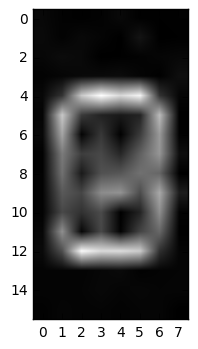

In [154]:
plt.imshow(avgimg[:,108:116], cmap='gray')

## Computing Max Image `maximg` and separation points for distinct digits
`maximg` aggregates over all images using the maximum of the pixel values.

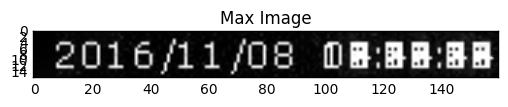

In [252]:
maximg = imgs[0]
for k in range(1, len(imgs)):
    maximg = np.maximum(maximg, imgs[k])
##avgimg/len(imgs)
plt.title('Max Image')
plt.imshow(maximg, cmap='gray')

Now, we reduce max image to a single row. Pixel columns that are always dark show up as minima, pixel rows of digits have values close to the maximum.

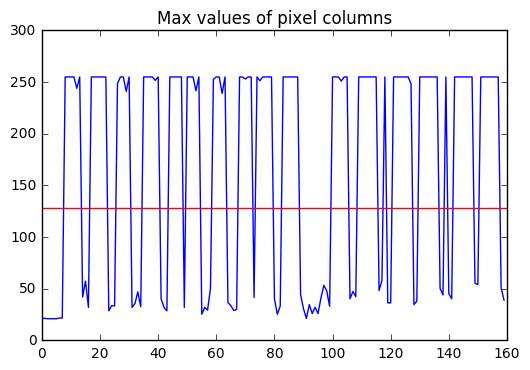

In [256]:
sep = maximg.max(axis=0)
plt.plot(sep)
plt.plot([0,160], [128, 128], 'r-')
plt.title('Max values of pixel columns')

In [258]:
breaks_temp = []
for k in range(1,len(bsep)):
    ##print(k, sep[k], sep[k-1])
    if (sep[k]>128) and (sep[k-1]<128):
        breaks_temp.append(k)
breaks_temp

[8, 17, 26, 35, 44, 50, 59, 68, 74, 83, 100, 109, 118, 121, 130, 139, 142, 151]

Some of the breaks are close together. They separate the slashes (/) in the date and colons (:) in the time fields. We use the requirements that as a digit is at least 6 pixels wide as criteria to eliminate those characters.

[8, 17, 26, 35, 50, 59, 74, 83, 100, 109, 121, 130, 142, 151]

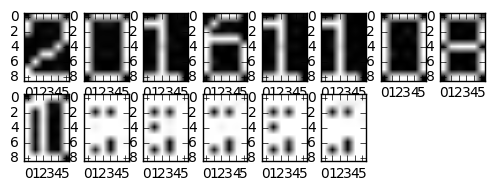

In [273]:
f = 1 ## just for subplot
breaks = [] ## new array for breaks 
for k in range(len(breaks_temp)):
    if (k==len(breaks_temp)-1) or (breaks_temp[k+1]-breaks_temp[k]>6):
        b = breaks_temp[k]
        breaks.append(b)
        plt.subplot(4,8, f)
        f+=1
        plt.imshow(maximg[4:13, b:b+6], cmap='gray')
breaks

In [275]:
digit = maximg[4:13,100:106].reshape(9*6, 1)
digit

array([[  19.33333333],
       [ 252.66666667],
       [ 255.        ],
       [ 251.        ],
       [ 255.        ],
       [  41.        ],
       [ 255.        ],
       [ 255.        ],
       [ 248.66666667],
       [  20.66666667],
       [  39.        ],
       [ 255.        ],
       [ 255.        ],
       [  20.66666667],
       [ 255.        ],
       [  30.33333333],
       [  20.33333333],
       [ 255.        ],
       [ 246.33333333],
       [  19.33333333],
       [ 248.66666667],
       [  16.        ],
       [  18.33333333],
       [ 255.        ],
       [ 252.        ],
       [  26.33333333],
       [ 255.        ],
       [  16.        ],
       [  26.66666667],
       [ 255.        ],
       [ 252.66666667],
       [  16.        ],
       [ 255.        ],
       [  16.        ],
       [  19.        ],
       [ 255.        ],
       [ 243.33333333],
       [  27.        ],
       [ 255.        ],
       [  17.        ],
       [  26.33333333],
       [ 255.   

In [284]:
x1s = []
for i in range(len(imgs)):
    for j in range(8,len(breaks)):
        x = imgs[i][4:13, breaks[j]: breaks[j]+6]
        x1s.append(x.reshape(9*6,))
X = np.vstack(x1s)

In [285]:
X.shape

(1536, 54)

In [286]:
from sklearn.cluster import KMeans

In [287]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
kmeans

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=0, tol=0.0001,
    verbose=0)

In [289]:
kmeans.cluster_centers_.shape

(10, 54)

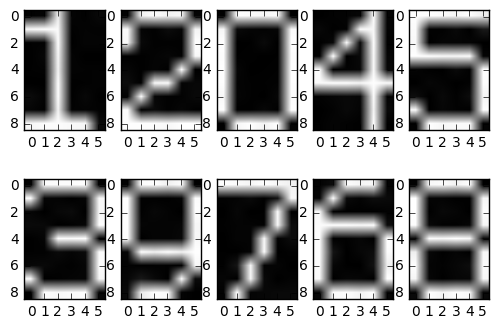

In [294]:
for k in range(10):
    plt.subplot(2,5, k+1)
    plt.imshow(kmeans.cluster_centers_[k].reshape(9,6), cmap='gray')

The $k$-Means algorithm finds the perfect centers for each digit. They are out of order, so we have to label them manually. Once that is done the optical character recognition can be performed by just finding the closest center point, i.e. $k$-Nearest-neighbor with $k = 1$.